In [38]:
# Install Hugging Face libraries (if needed)
!pip install datasets transformers

# 1. Load the raw WikiText-2 dataset
from datasets import load_dataset

ds = load_dataset("EleutherAI/wikitext_document_level", "wikitext-2-raw-v1")
ds

DatasetDict({
    train: Dataset({
        features: ['page'],
        num_rows: 629
    })
    validation: Dataset({
        features: ['page'],
        num_rows: 60
    })
    test: Dataset({
        features: ['page'],
        num_rows: 62
    })
})

In [39]:
print(ds)
print(ds["train"][0])


DatasetDict({
    train: Dataset({
        features: ['page'],
        num_rows: 629
    })
    validation: Dataset({
        features: ['page'],
        num_rows: 60
    })
    test: Dataset({
        features: ['page'],
        num_rows: 62
    })
})
{'page': ' = Valkyria Chronicles III = \n \n Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " 

In [40]:
import re
#Clean rge dataset
def clean_text(example):
    text = example["page"]

    # Remove Wiki-style section headers
    text = re.sub(r"=+\s.*?\s=+", "", text)

    # Remove multiple blank lines
    text = re.sub(r"\n{2,}", "\n", text)

    # Strip leading/trailing spaces
    text = text.strip()

    return {"page": text}

cleaned_ds = ds.map(clean_text)

In [41]:
#Tokenize the dataset
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # important for padding

def tokenize_function(examples):
    return tokenizer(examples["page"])

tokenized_datasets = cleaned_ds.map(
    tokenize_function,
    batched=True,
    remove_columns=["page"]
)

tokenized_datasets

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1254 > 1024). Running this sequence through the model will result in indexing errors


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 629
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 60
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 62
    })
})

In [42]:
#Group tokens into fixed-length blocks for language modeling
block_size = 128

def group_texts(examples):
    # Concatenate all texts
    concatenated = []
    for ids in examples["input_ids"]:
        concatenated.extend(ids)
    total_length = len(concatenated)
    total_length = (total_length // block_size) * block_size  # drop remainder

    result = {
        "input_ids": [],
        "attention_mask": []
    }
    for i in range(0, total_length, block_size):
        result["input_ids"].append(concatenated[i : i + block_size])
        result["attention_mask"].append([1] * block_size)
    return result

lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True
)

lm_datasets

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 18611
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1924
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 2204
    })
})

In [43]:
#Fine tune the model
from transformers import (
    GPT2LMHeadModel,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
import os # Import os module

# Ensure wandb is disabled before any wandb initialization attempt
os.environ["WANDB_DISABLED"] = "true"

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.eos_token_id

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

training_args = TrainingArguments(
    output_dir="./gpt2-wikitext-checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    push_to_hub=False,
    report_to="none", # Ensures Trainer doesn't try to log to wandb
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,3.387900,3.373041
2,3.203200,3.362735


TrainOutput(global_step=4654, training_loss=3.3680098990180944, metrics={'train_runtime': 834.6359, 'train_samples_per_second': 44.597, 'train_steps_per_second': 5.576, 'total_flos': 2431453003776000.0, 'train_loss': 3.3680098990180944, 'epoch': 2.0})

In [44]:
save_path = "./fine_tuned_gpt2"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print("Model saved to:", save_path)

Model saved to: ./fine_tuned_gpt2


In [45]:
import math

eval_results = trainer.evaluate()
print("Perplexity:", math.exp(eval_results["eval_loss"]))

Perplexity: 28.868031160328638


In [46]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = "cuda" if torch.cuda.is_available() else "cpu"

# base (original) GPT-2
base_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
base_tokenizer.pad_token = base_tokenizer.eos_token
base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

# fine-tuned model already in memory as `model`
ft_model = model.to(device)
ft_tokenizer = tokenizer   # same tokenizer you used for training

torch.manual_seed(42)      # for reproducible-ish samples

prompts = [
    "In modern machine learning research,",
    "Climate change policy must balance",
    "The history of Valkyria Chronicles begins with",
]

def generate_text(model, tok, prompt, max_new_tokens=80):
    inputs = tok(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=0.8,
            pad_token_id=tok.eos_token_id,
        )
    return tok.decode(out_ids[0], skip_special_tokens=True)

for p in prompts:
    print("=" * 80)
    print("PROMPT:\n", p)
    print("\n--- Base GPT-2 ---")
    print(generate_text(base_model, base_tokenizer, p))
    print("\n--- Fine-tuned GPT-2 ---")
    print(generate_text(ft_model, ft_tokenizer, p))
    print()

PROMPT:
 In modern machine learning research,

--- Base GPT-2 ---
In modern machine learning research, we have no way of knowing what is going to happen in the future, but it's clear that there are things we can do to improve the speed at which machines learn.

In particular, we can use a high-level model called neural network theory (NN). It's very simple. It's a model that describes a model of the brain. It's the way in which we know

--- Fine-tuned GPT-2 ---
In modern machine learning research, the term " machine learning " has become synonymous with machine learning , and has been used as a synonym for machine learning research . 
 
  = 
 
 In the United States , machine learning is a relatively new field , and its application in the field of machine learning has been limited to academic research . It has not been the focus of much research , and is now being used

PROMPT:
 Climate change policy must balance

--- Base GPT-2 ---
Climate change policy must balance the needs of workin

In [47]:
import math
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, Trainer, TrainingArguments

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- Base (original) GPT-2 -----
base_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
base_tokenizer.pad_token = base_tokenizer.eos_token
base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

base_eval_args = TrainingArguments(
    output_dir="./tmp_base_eval",
    per_device_eval_batch_size=2,
    report_to="none"
)

base_eval_trainer = Trainer(
    model=base_model,
    args=base_eval_args,
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

base_results = base_eval_trainer.evaluate()
base_ppl = math.exp(base_results["eval_loss"])
print("Base GPT-2 Perplexity:", base_ppl)

# ----- Fine-tuned GPT-2 -----
# If `model` is already your fine-tuned GPT-2:
ft_model = model.to(device)

ft_eval_args = TrainingArguments(
    output_dir="./tmp_ft_eval",
    per_device_eval_batch_size=2,
    report_to="none"
)

ft_eval_trainer = Trainer(
    model=ft_model,
    args=ft_eval_args,
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

ft_results = ft_eval_trainer.evaluate()
ft_ppl = math.exp(ft_results["eval_loss"])
print("Fine-tuned GPT-2 Perplexity:", ft_ppl)

print("\n=== Perplexity Comparison ===")
print(f"Base GPT-2:       {base_ppl:.2f}")
print(f"Fine-tuned GPT-2: {ft_ppl:.2f}")
print("=============================")


Base GPT-2 Perplexity: 56.68196234043284


Fine-tuned GPT-2 Perplexity: 28.868031160328638

=== Perplexity Comparison ===
Base GPT-2:       56.68
Fine-tuned GPT-2: 28.87


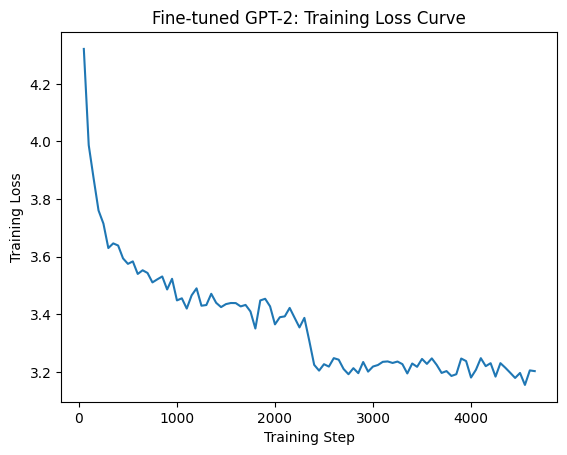

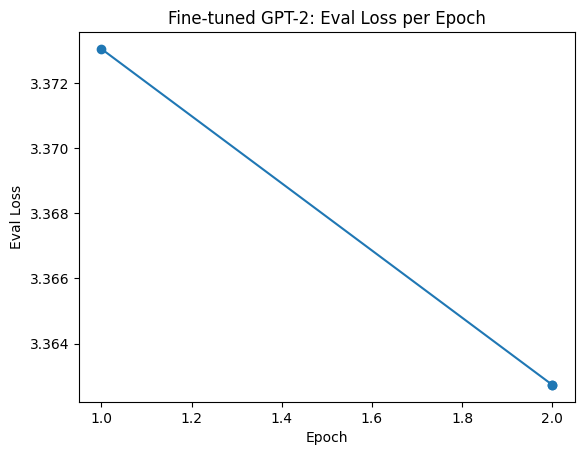

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# `trainer` is the Trainer you used for fine-tuning
logs = pd.DataFrame(trainer.state.log_history)

# Training loss
train_logs = logs[logs["loss"].notnull()]

plt.figure()
plt.plot(train_logs["step"], train_logs["loss"])
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Fine-tuned GPT-2: Training Loss Curve")
plt.show()

# (Optional) Evaluation loss per epoch if available
if "eval_loss" in logs.columns:
    eval_logs = logs[logs["eval_loss"].notnull()]
    if not eval_logs.empty:
        plt.figure()
        plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Eval Loss")
        plt.title("Fine-tuned GPT-2: Eval Loss per Epoch")
        plt.show()

In [49]:
import itertools
from collections import Counter

device = "cuda" if torch.cuda.is_available() else "cpu"

# Reuse base_model, base_tokenizer, ft_model, tokenizer (fine-tuned)
base_model.eval()
ft_model.eval()

prompts = [
    "In modern machine learning research,",
    "Climate change policy must balance",
    "The history of artificial intelligence begins with",
    "In recent years, neural networks have",
]

def generate_texts(model, tok, prompts, num_samples_per_prompt=3, max_new_tokens=60):
    texts = []
    torch.manual_seed(42)  # for reproducibility
    for prompt in prompts:
        inputs = tok(prompt, return_tensors="pt").to(device)
        for _ in range(num_samples_per_prompt):
            with torch.no_grad():
                out_ids = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    top_k=50,
                    top_p=0.9,
                    temperature=0.8,
                    pad_token_id=tok.eos_token_id,
                )
            text = tok.decode(out_ids[0], skip_special_tokens=True)
            texts.append(text)
    return texts

def compute_distinct_n(texts, n=1):
    ngrams = []
    for txt in texts:
        # simple whitespace tokenization
        tokens = txt.split()
        if len(tokens) < n:
            continue
        ngrams.extend(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1))
    if not ngrams:
        return 0.0
    total = len(ngrams)
    unique = len(set(ngrams))
    return unique / total

# Generate outputs
base_gen_texts = generate_texts(base_model, base_tokenizer, prompts)
ft_gen_texts   = generate_texts(ft_model, tokenizer, prompts)

# Compute diversity metrics
base_dist1 = compute_distinct_n(base_gen_texts, n=1)
base_dist2 = compute_distinct_n(base_gen_texts, n=2)

ft_dist1 = compute_distinct_n(ft_gen_texts, n=1)
ft_dist2 = compute_distinct_n(ft_gen_texts, n=2)

print("=== Generation Diversity (Distinct-n) ===")
print("Base GPT-2:")
print(f"  Distinct-1: {base_dist1:.4f}")
print(f"  Distinct-2: {base_dist2:.4f}")

print("\nFine-tuned GPT-2:")
print(f"  Distinct-1: {ft_dist1:.4f}")
print(f"  Distinct-2: {ft_dist2:.4f}")
print("=========================================")

=== Generation Diversity (Distinct-n) ===
Base GPT-2:
  Distinct-1: 0.4682
  Distinct-2: 0.8241

Fine-tuned GPT-2:
  Distinct-1: 0.3771
  Distinct-2: 0.7601


In [50]:
import math
from transformers import Trainer, TrainingArguments

# ---- Evaluation for Base Model ----
base_eval_args = TrainingArguments(
    output_dir="./tmp_eval_base",
    per_device_eval_batch_size=2,
    report_to="none",
)

base_eval_trainer = Trainer(
    model=base_model,
    args=base_eval_args,
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

base_results = base_eval_trainer.evaluate()
base_eval_loss = base_results["eval_loss"]

# ---- Evaluation for Fine-Tuned Model ----
ft_eval_args = TrainingArguments(
    output_dir="./tmp_eval_ft",
    per_device_eval_batch_size=2,
    report_to="none",
)

ft_eval_trainer = Trainer(
    model=model,   # your fine-tuned GPT-2
    args=ft_eval_args,
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

ft_results = ft_eval_trainer.evaluate()
ft_eval_loss = ft_results["eval_loss"]

print("Base eval loss:", base_eval_loss)
print("Fine-tuned eval loss:", ft_eval_loss)

Base eval loss: 4.037456035614014
Fine-tuned eval loss: 3.362734794616699
